In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

service=QiskitRuntimeService()

In [4]:
import numpy as np
from qiskit import QuantumCircuit

# 1. A quantum circuit for preparing the quantum state |000> + i |111>
qc_example = QuantumCircuit(3)
qc_example.h(0)          # generate superpostion
qc_example.p(np.pi/2,0)  # add quantum phase
qc_example.cx(0,1)       # 0th-qubit-Controlled-NOT gate on 1st qubit
qc_example.cx(0,2) 

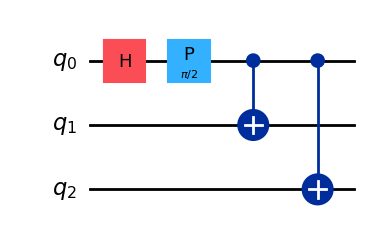

In [5]:
qc_example.draw(output="mpl")

In [6]:
from qiskit.quantum_info import SparsePauliOp 

operator=SparsePauliOp.from_list([("XXY",1),("XYX",1),("YXX",1),("YYY",-1)])

print(operator)

SparsePauliOp(['XXY', 'XYX', 'YXX', 'YYY'],
              coeffs=[ 1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j])


In [16]:
from qiskit.primitives import StatevectorEstimator

estimator=StatevectorEstimator()
job=estimator.run(pubs=[(qc_example,operator)])
result=job.result()[0]

print(f"Expectation Values: {result.data.evs}")

Expectation Values: 3.999999999999999


In [20]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager 
from qiskit_ibm_runtime import EstimatorV2 as Estimator

backend=service.backend("ibm_brisbane")
pm=generate_preset_pass_manager(optimization_level=2,backend=backend)

opt_qc=pm.run(qc_example)
isa_observable=operator.apply_layout(opt_qc.layout)

estimator=Estimator(mode=backend)
pubs=estimator.run([(opt_qc,isa_observable)])

print(f"Job id: {pubs.job_id()}")

result=pubs.result()[0]
print(f"Expectation Values: {result.data.evs}")

Job id: cvt5mgtx1h0g0082q0mg
Expectation Values: 3.9555796316359695


In [21]:
evs_val={"Simulator":3.999999999999999,
         "ibm_brisbane":3.9555796316359695}
fidelity=abs(evs_val["Simulator"]-evs_val["ibm_brisbane"])
print(f"Absolute error: {fidelity}")

Absolute error: 0.04442036836402963


In [23]:
from qiskit.utils import local_hardware_info
import json as js
info=local_hardware_info()
print(js.dumps(info,indent=2))

{
  "python_compiler": "MSC v.1933 64 bit (AMD64)",
  "python_build": "main, Oct 24 2022 18:26:48",
  "python_version": "3.11.0",
  "os": "Windows",
  "cpus": 4
}


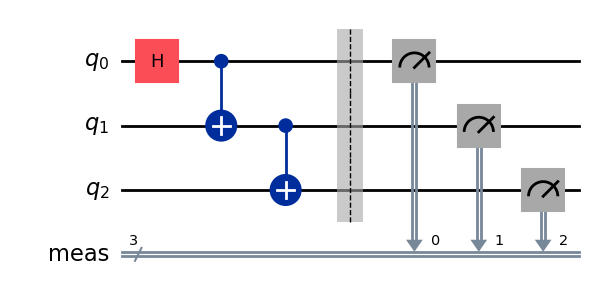

In [42]:
from qiskit.quantum_info import DensityMatrix 

qc=QuantumCircuit(3)

qc.h(0)
qc.cx(0,1)
qc.cx(1,2)


qc.measure_all()
qc.draw("mpl")

In [43]:
qc.remove_final_measurements()
zeros=DensityMatrix.from_label("000")
zeros.draw("latex")

<IPython.core.display.Latex object>

In [44]:
dv=zeros.evolve(qc)
dv.draw("latex")

<IPython.core.display.Latex object>

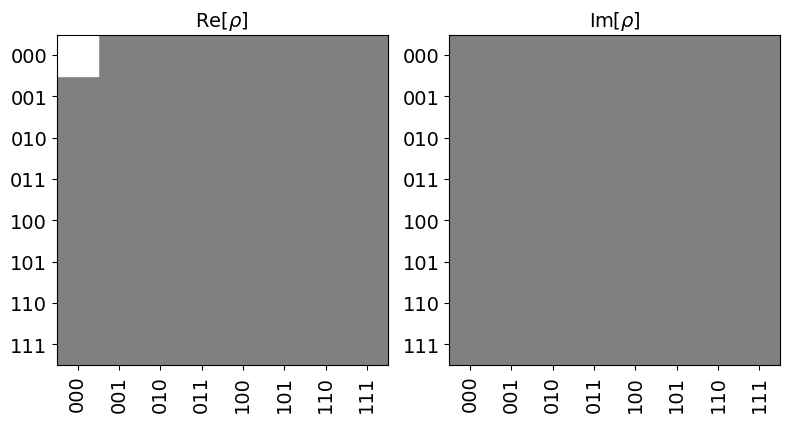

In [45]:
zeros.draw(output="hinton")

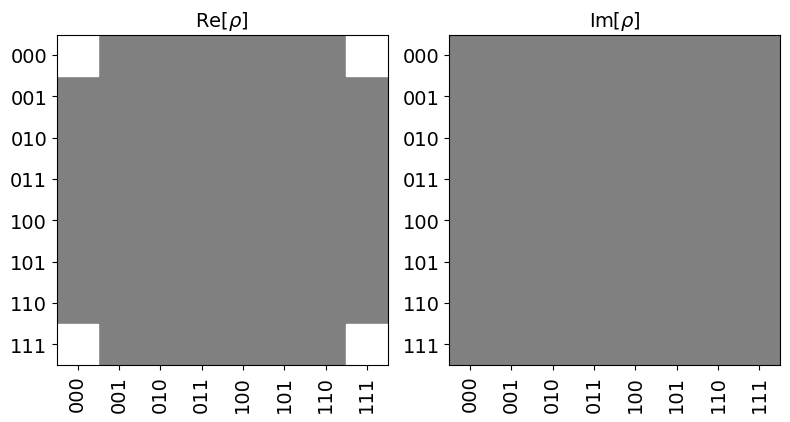

In [46]:
dv.draw("hinton")

In [49]:
from qiskit_ibm_runtime import SamplerV2 as Sampler 

sampler=Sampler(mode=backend)
opt_qc=pm.run(qc)

print(f"Circuit Depth before transpiling : {qc.depth()}")
print(f"Circuit depth after transpilation: {opt_qc.depth()}")

Circuit Depth before transpiling : 3
Circuit depth after transpilation: 15


In [67]:
def build_circuit(n,backend):
    pm=generate_preset_pass_manager(optimization_level=2,backend=backend)
    qc=QuantumCircuit(n)
    qc.h(0)
    for i in range (0,n-1):
        qc.cx(i,i+1)
    opt_qc=pm.run(qc)
    return (qc.depth(),opt_qc.depth())


In [ ]:
backend=service.backend("ibm_brisbane")
main_depth=[]
transpiled_depth=[]
for i in range (1,100):
    a,b=build_circuit(i,backend)
    main_depth.append(a); transpiled_depth.append(b)


In [70]:
backend=service.backend("ibm_kyiv")
pm=generate_preset_pass_manager(optimization_level=2,backend=backend)

main_depth_kyiv=[]
transpiled_depth_kyiv=[]
for i in range (1,100):
    a,b=build_circuit(i,backend)
    main_depth_kyiv.append(a); transpiled_depth_kyiv.append(b)

In [72]:
backend=service.backend("ibm_sherbrooke")

main_depth_sh=[]
transpiled_depth_sh=[]
for i in range (1,100):
    a,b=build_circuit(i,backend)
    main_depth_sh.append(a); transpiled_depth_sh.append(b)

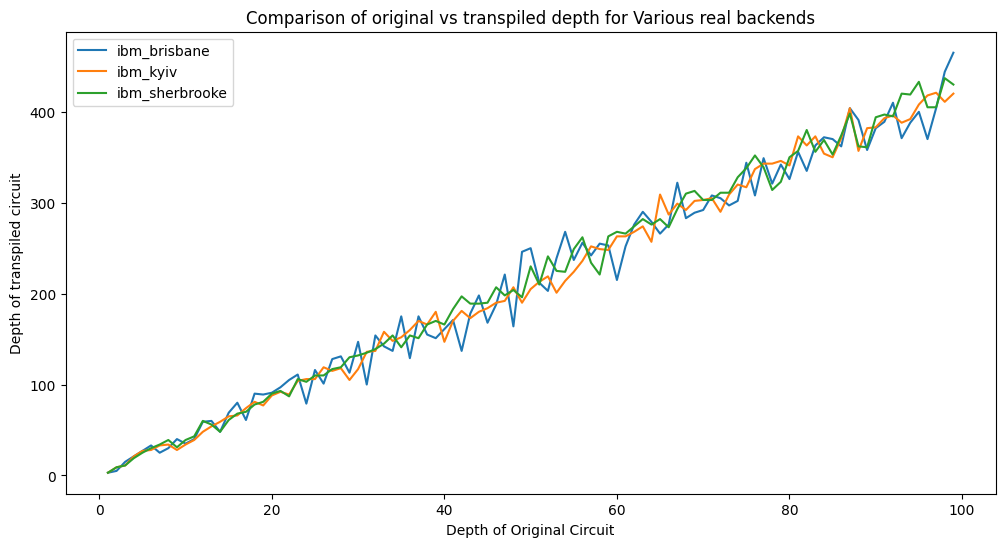

In [86]:
plt.figure(figsize=(12,6))
plt.plot(main_depth,transpiled_depth,label="ibm_brisbane")
plt.plot(main_depth_kyiv,transpiled_depth_kyiv,label="ibm_kyiv")
plt.plot(main_depth_sh,transpiled_depth_sh,label="ibm_sherbrooke")
plt.xlabel("Depth of Original Circuit")
plt.ylabel("Depth of transpiled circuit")
plt.title(f"Comparison of original vs transpiled depth for Various real backends")
plt.legend()

plt.show()


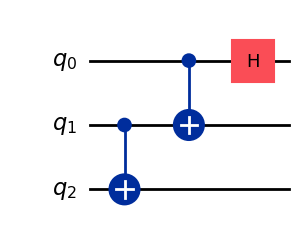

In [87]:
qc_inv=qc.inverse()
qc_inv.draw(output="mpl")

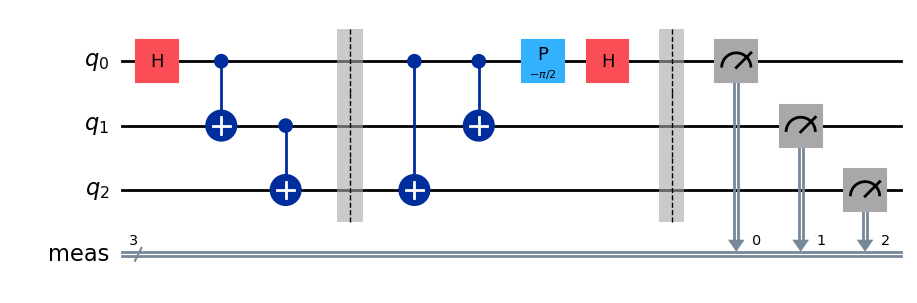

In [95]:
from qiskit.circuit.library import UnitaryOverlap

overlap=UnitaryOverlap(qc,qc_example)

overlap.measure_all()

overlap.draw(output="mpl")

In [96]:
from qiskit.primitives import StatevectorSampler

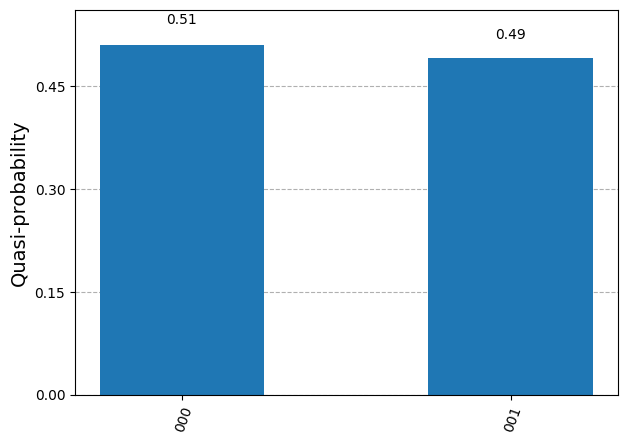

In [98]:
sampler = StatevectorSampler(default_shots=100)
pubs = sampler.run(pubs=[overlap])
result=pubs.result()[0]
 
# the fidelity is the probability to measure 0
fidelity = result.data.meas.get_counts()

from qiskit.visualization import plot_distribution 

plot_distribution(fidelity)

In [102]:
backend=service.backend("ibm_brisbane")

pm=generate_preset_pass_manager(optimization_level=2,backend=backend)
opt_qc=pm.run(overlap)

sampler=Sampler(mode=backend)
pubs=sampler.run([opt_qc],shots=1024) 

print(f"Job Id: {pubs.job_id()}")

result=pubs.result()[0]

Job Id: cvt6azvqgh400088mk80


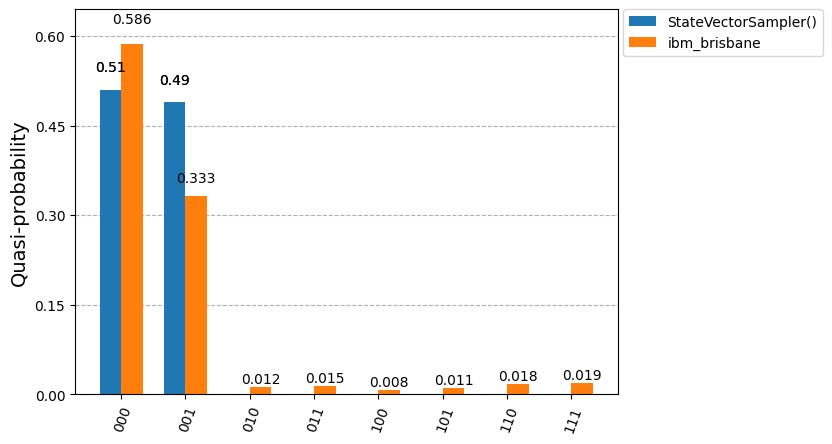

In [106]:
counts=result.data.meas.get_counts()

plot_distribution([fidelity,counts],legend=["StateVectorSampler()","ibm_brisbane"])